<a href="https://colab.research.google.com/github/NancyBiyahut/intrusion-detection-autoencoder/blob/main/LSTMautoencoder_cic_2017_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from mpl_toolkits import mplot3d
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from scipy.spatial.distance import euclidean
import random
import seaborn as sns
from itertools import combinations, product
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [ ]:
df1= pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2 = pd.read_csv('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df3 = pd.read_csv('Friday-WorkingHours-Morning.pcap_ISCX.csv')
df4 = pd.read_csv('Monday-WorkingHours.pcap_ISCX.csv')
df5 = pd.read_csv('Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
df6 = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df7 = pd.read_csv('Tuesday-WorkingHours.pcap_ISCX.csv')
df8 = pd.read_csv('Wednesday-workingHours.pcap_ISCX.csv')
df = pd.concat([df1, df2, df3 , df4,df5,df6,df7,df8], ignore_index=True)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,55054,109,1,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,55055,52,1,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,46236,34,1,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,54863,3,2,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [ ]:
np.random.seed(42)
# Sample a small subset of data for testing (e.g., 20%)
df = df.sample(frac=0.4 ,random_state=42)
print(df.shape)

(1121886, 79)


In [ ]:
# List all column names and their data types
column_datatypes = df.dtypes

# Print column names and their data types
for column_name, datatype in column_datatypes.items():
    print(f"Column: {column_name}, Datatype: {datatype}")

Column:  Destination Port, Datatype: int64
Column:  Flow Duration, Datatype: int64
Column:  Total Fwd Packets, Datatype: int64
Column:  Total Backward Packets, Datatype: float64
Column: Total Length of Fwd Packets, Datatype: float64
Column:  Total Length of Bwd Packets, Datatype: float64
Column:  Fwd Packet Length Max, Datatype: float64
Column:  Fwd Packet Length Min, Datatype: float64
Column:  Fwd Packet Length Mean, Datatype: float64
Column:  Fwd Packet Length Std, Datatype: float64
Column: Bwd Packet Length Max, Datatype: float64
Column:  Bwd Packet Length Min, Datatype: float64
Column:  Bwd Packet Length Mean, Datatype: float64
Column:  Bwd Packet Length Std, Datatype: float64
Column: Flow Bytes/s, Datatype: float64
Column:  Flow Packets/s, Datatype: float64
Column:  Flow IAT Mean, Datatype: float64
Column:  Flow IAT Std, Datatype: float64
Column:  Flow IAT Max, Datatype: float64
Column:  Flow IAT Min, Datatype: float64
Column: Fwd IAT Total, Datatype: float64
Column:  Fwd IAT Mean

In [ ]:
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df
df = clean_df(df)
test_df_http = df.sample(frac=0.2, random_state=42)

dataset shape (1121886, 79)
zero variance columns [] dropped
shape after removing zero variance columns: (1121886, 79)
1159 rows dropped
shape after removing nan: (1120727, 79)
shape after dropping duplicates: (1031279, 79)
columns which have identical values [('Total Backward Packets', 'Subflow Bwd Packets'), ('Fwd PSH Flags', 'SYN Flag Count'), ('Bwd PSH Flags', 'Bwd URG Flags'), ('Bwd PSH Flags', 'Fwd Avg Bytes/Bulk'), ('Bwd PSH Flags', 'Fwd Avg Packets/Bulk'), ('Bwd PSH Flags', 'Fwd Avg Bulk Rate'), ('Bwd PSH Flags', 'Bwd Avg Bytes/Bulk'), ('Bwd PSH Flags', 'Bwd Avg Packets/Bulk'), ('Bwd PSH Flags', 'Bwd Avg Bulk Rate'), ('Fwd URG Flags', 'CWE Flag Count'), ('Bwd URG Flags', 'Fwd Avg Bytes/Bulk'), ('Bwd URG Flags', 'Fwd Avg Packets/Bulk'), ('Bwd URG Flags', 'Fwd Avg Bulk Rate'), ('Bwd URG Flags', 'Bwd Avg Bytes/Bulk'), ('Bwd URG Flags', 'Bwd Avg Packets/Bulk'), ('Bwd URG Flags', 'Bwd Avg Bulk Rate'), ('Fwd Header Length', 'Fwd Header Length.1'), ('Fwd Avg Bytes/Bulk', 'Fwd Avg Pack

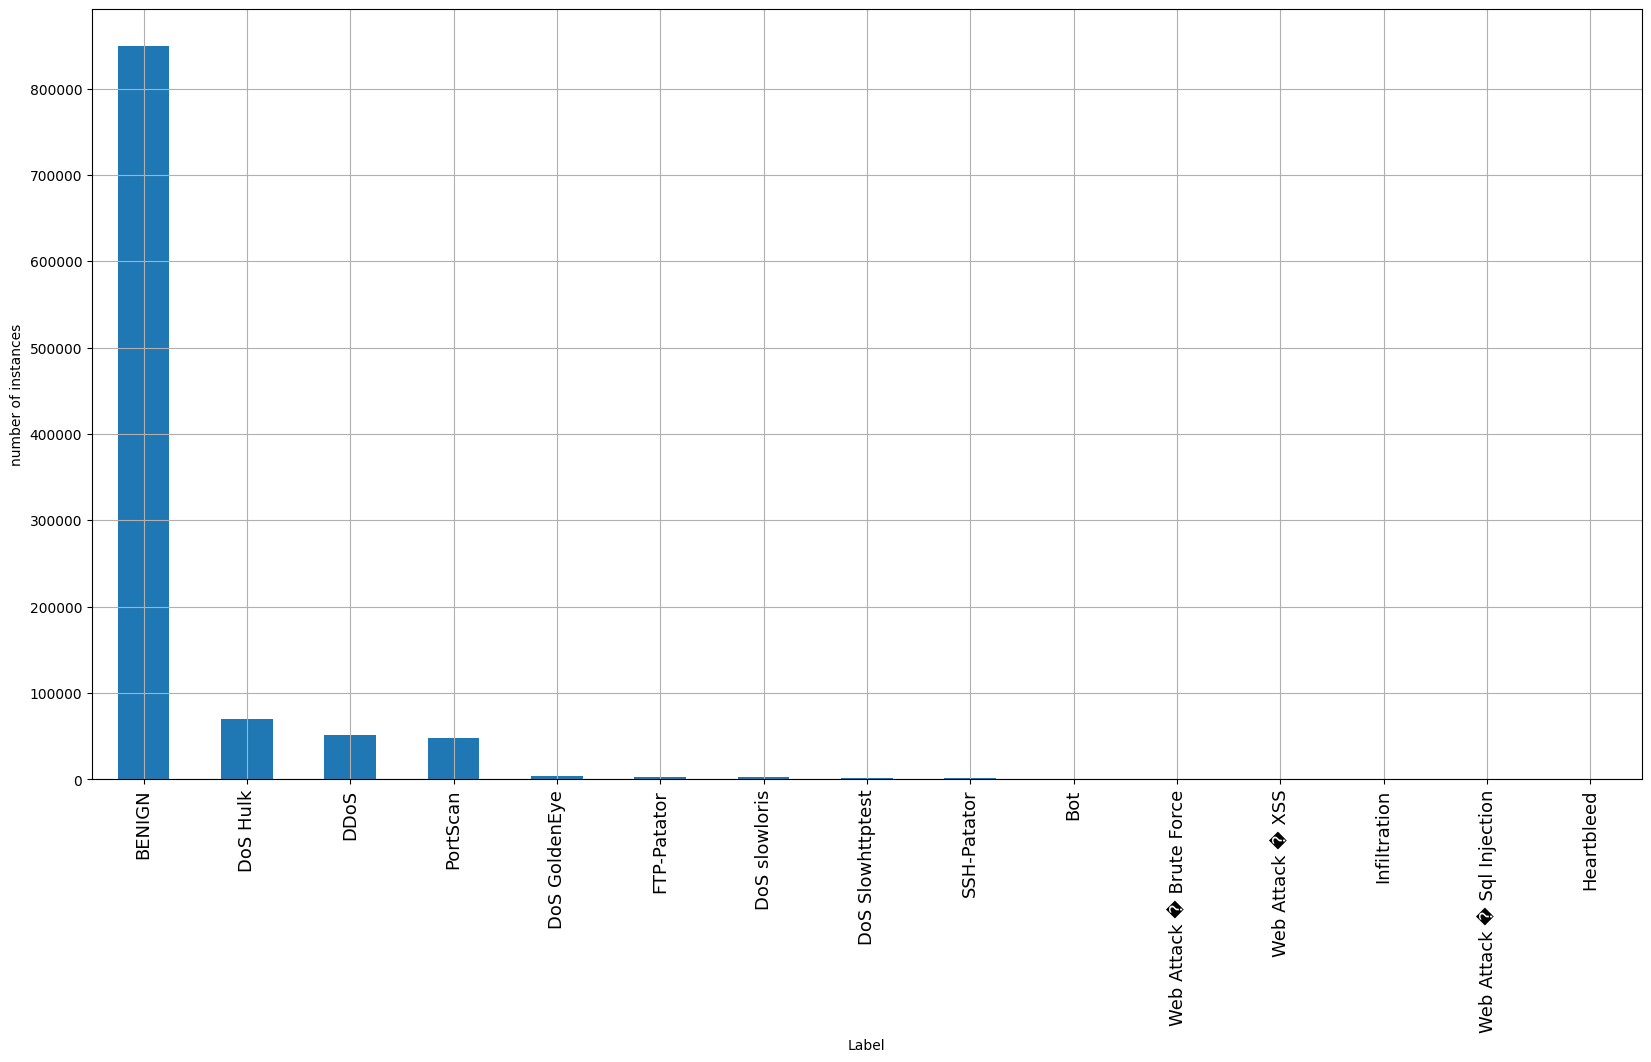

In [ ]:
pd.value_counts(df['Label']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

In [ ]:
normal_instances = df[df['Label']=='BENIGN'].shape[0]
anomalous_instances = df[df['Label']!='BENIGN'].shape[0]
print(normal_instances)
print(anomalous_instances)
print('percentage of anomalies = {}'.format(100*anomalous_instances/normal_instances))

849273
182006
percentage of anomalies = 21.430800225604724


In [ ]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2751693,53,30644,2,2.0,74.0,186.0,37.0,37.0,37.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1552108,53,117077,2,2.0,60.0,264.0,30.0,30.0,30.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
17145,80,200406,1,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2792702,53,301,2,2.0,62.0,238.0,31.0,31.0,31.0,0.0,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
325143,1801,18,1,1.0,2.0,6.0,2.0,2.0,2.0,0.0,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PortScan


In [ ]:
df_http_normal = df[df['Label']=='BENIGN']
df_http_normal.drop(columns=['Label'] , inplace=True)
df_http_normal.describe()

<ipython-input-75-291c4d03b4f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_normal.drop(columns=['Label'] , inplace=True)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,849273.000000,8.492730e+05,849273.000000,849273.000000,8.492730e+05,8.492730e+05,849273.000000,849273.000000,849273.000000,849273.000000,...,849273.000000,849273.000000,8.492730e+05,8.492730e+05,8.492730e+05,8.492730e+05,8.492730e+05,8.492730e+05,8.492730e+05,8.492730e+05
mean,9846.569460,1.193283e+07,10.852897,12.400180,6.853218e+02,1.892178e+04,244.837767,22.943087,69.619583,79.771229,...,6.640861,25.852351,8.159040e+04,4.937447e+04,1.724614e+05,5.437281e+04,3.970492e+06,2.848474e+05,4.180368e+06,3.719123e+06
std,20148.987682,3.092346e+07,829.939707,1105.927717,1.561716e+04,2.497559e+06,816.798898,65.617210,211.253298,321.893541,...,739.217301,6.374916,6.469604e+05,4.231378e+05,1.095112e+06,5.607232e+05,1.383359e+07,3.121112e+06,1.449324e+07,1.352554e+07
min,0.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,1.960000e+02,2.000000,1.000000,1.200000e+01,6.000000e+00,6.000000,0.000000,6.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,3.420200e+04,2.000000,2.000000,6.800000e+01,1.410000e+02,41.000000,6.000000,38.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,443.000000,9.919980e+05,4.000000,3.000000,1.880000e+02,3.580000e+02,85.000000,40.000000,52.000000,26.162951,...,3.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65534.000000,1.200000e+08,214125.000000,284602.000000,1.290000e+07,6.296006e+08,24820.000000,2065.000000,4640.757576,7125.596846,...,204290.000000,138.000000,1.060000e+08,7.420000e+07,1.060000e+08,1.060000e+08,1.200000e+08,7.660000e+07,1.200000e+08,1.200000e+08


In [ ]:
# scaling the data using standard scaler
scaler = StandardScaler()
df_http_normal = pd.DataFrame(scaler.fit_transform(df_http_normal), columns=df_http_normal.columns)

In [ ]:
# reducing the dimensionality of the data using PCA and covering 80% of the variance in the original data
pca = PCA(n_components=0.80)
pca.fit(df_http_normal)

PCA(n_components=0.8)

In [ ]:
pca_cols = ['PCA_'+ str(i) for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca.transform(df_http_normal), columns=pca_cols)

In [ ]:
df_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12
0,-1.653716,-0.193486,0.341448,-0.279243,-1.335539,0.518554,-0.147453,-0.300968,0.043452,0.090604,-0.098894,-0.114417,0.228452
1,-1.543532,-0.134844,0.263945,-0.349175,-1.351975,0.512611,-0.074597,-0.345060,0.077275,0.001366,0.015985,0.125866,-0.179970
2,-1.900204,-0.468897,0.718074,1.037601,0.930996,0.139999,-0.563176,1.591992,-0.289175,-0.697279,0.802767,-0.280988,-0.214625
3,-1.654022,-0.147599,0.284564,-0.375257,-1.356775,0.447092,-0.113005,-0.381013,0.025971,0.066128,-0.045080,-0.272797,0.538058
4,-1.868023,-0.373470,0.579273,0.405335,0.883156,-0.003372,-0.441483,0.392366,-0.056685,0.507767,-0.677792,0.282743,0.441270


In [ ]:
def get_windows(df, window_size=20, stride=10):
  windows_arr = []
  for i in tqdm.tqdm(range(0, len(df)-window_size+1, stride)):
    windows_arr.append(df.iloc[i:i+window_size, :].to_numpy())
  return np.array(windows_arr)

In [ ]:
window_size, stride = 10, 10
windows_arr = get_windows(df_pca, window_size, stride)

100%|██████████| 84927/84927 [00:07<00:00, 11557.68it/s]


In [ ]:
# shuffling windows for training purpose
indices = np.arange(windows_arr.shape[0])
np.random.shuffle(indices)
windows_shuffled = windows_arr[indices]

LSTM Autoencoder

In [ ]:
K.clear_session()
# encoder model with stacked LSTM
encoder = Sequential([LSTM(80, return_sequences=True, activation='selu',input_shape=(window_size, 13), dropout=0.2), LSTM(50, activation='selu', return_sequences=True),
                      LSTM(20, activation='selu')], name='encoder')
# decoder model with output dimension same as input dimension
decoder = Sequential([RepeatVector(window_size), LSTM(50, activation='selu', return_sequences=True), LSTM(80, activation='selu',return_sequences=True),
                      TimeDistributed(Dense(13, activation='linear'))], name='decoder')
# creating sequential autoencoder using encoder, decoder as layers
autoencoder = Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(optimizer='adam', loss = tf.keras.losses.Huber(100.))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 20)                61960     
                                                                 
 decoder (Sequential)        (None, 10, 13)            57173     
                                                                 
Total params: 119133 (465.36 KB)
Trainable params: 119133 (465.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
encoder.summary(), decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 80)            30080     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            26200     
                                                                 
 lstm_2 (LSTM)               (None, 20)                5680      
                                                                 
Total params: 61960 (242.03 KB)
Trainable params: 61960 (242.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector (RepeatVecto  (None, 10, 20)            0         
 r)                                                              
    

(None, None)

In [ ]:
check_point = tf.keras.callbacks.ModelCheckpoint('autoencoder.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
train_hist = autoencoder.fit(windows_shuffled, windows_shuffled[:, :, ::-1], batch_size=64, validation_split=0.2, epochs=50, callbacks=[check_point])

Epoch 1/50
1062/1062 [==============================] - ETA: 0s - loss: 1.2748
Epoch 1: val_loss improved from inf to 1.05759, saving model to autoencoder.h5
1062/1062 [==============================] - 103s 80ms/step - loss: 1.2748 - val_loss: 1.0576
Epoch 2/50
   3/1062 [..............................] - ETA: 46s - loss: 0.7606

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1062/1062 [==============================] - ETA: 0s - loss: 0.9951
Epoch 2: val_loss did not improve from 1.05759
1062/1062 [==============================] - 86s 81ms/step - loss: 0.9951 - val_loss: 1.0639
Epoch 3/50
1061/1062 [============================>.] - ETA: 0s - loss: 0.9398
Epoch 3: val_loss improved from 1.05759 to 0.89454, saving model to autoencoder.h5
1062/1062 [==============================] - 74s 70ms/step - loss: 0.9397 - val_loss: 0.8945
Epoch 4/50
1062/1062 [==============================] - ETA: 0s - loss: 0.8894
Epoch 4: val_loss improved from 0.89454 to 0.86617, saving model to autoencoder.h5
1062/1062 [==============================] - 82s 77ms/step - loss: 0.8894 - val_loss: 0.8662
Epoch 5/50
1061/1062 [============================>.] - ETA: 0s - loss: 0.8442
Epoch 5: val_loss improved from 0.86617 to 0.85448, saving model to autoencoder.h5
1062/1062 [==============================] - 85s 80ms/step - loss: 0.8441 - val_loss: 0.8545
Epoch 6/50
1062/1062 [=====

In [ ]:
# restoring the best model
autoencoder_loaded = tf.keras.models.load_model('autoencoder.h5')

Testing

In [ ]:
test_df_http = df.sample(frac=0.2, random_state=42)

In [ ]:
print(test_df_http.shape)
test_df_http.head()

(206256, 68)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1898149,443,293,3,0.0,53.0,0.0,53.0,0.0,17.666667,30.599564,...,20.0,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,BENIGN
866178,80,119357267,40,39.0,5518.0,38961.0,1261.0,0.0,137.950000,266.710633,...,32.0,359078.454545,1.112796e+06,3714286.0,23514.0,1.002065e+07,8538.533931,10024480.0,10000408.0,BENIGN
480331,3659,67,1,1.0,2.0,6.0,2.0,2.0,2.000000,0.000000,...,24.0,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,PortScan
1873386,443,5540491,10,7.0,349.0,4839.0,192.0,0.0,34.900000,67.922259,...,32.0,233671.000000,0.000000e+00,233671.0,233671.0,5.306791e+06,0.000000,5306791.0,5306791.0,BENIGN
1877141,80,23682,1,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,20.0,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,BENIGN


In [ ]:
# binary indicator to represent anomalies
status = pd.Series([0 if i=='BENIGN' else 1 for i in test_df_http['Label']])
test_labels = [1 if np.sum(status[i:i+window_size])>0 else 0 for i in range(0, len(status)-window_size+1, stride)]

In [ ]:
test_df_http.drop(columns=['Label'], inplace=True)

In [ ]:
test_df_http = pd.DataFrame(scaler.fit_transform(test_df_http), columns=test_df_http.columns)

In [ ]:
test_df_http_pca = pd.DataFrame(pca.transform(test_df_http), columns=pca_cols)
test_df_http_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12
0,-1.621893,0.014241,-0.005481,-0.027215,1.369812,-0.567016,-0.415600,0.902728,-0.056043,0.841147,-1.349981,0.392655,0.716234
1,4.563019,1.680383,-2.154147,-2.002719,2.070451,2.352219,0.362167,-0.062981,-0.119534,1.813597,-0.820575,-1.341448,-3.160091
2,-1.722487,-0.054008,0.102037,-0.410651,0.235452,0.110352,-0.492330,0.289286,-0.015146,0.404943,-0.518690,0.748467,-0.229210
3,0.081785,0.955680,-1.326989,-1.419175,0.526198,-0.560530,0.031535,0.441281,-0.064486,0.543002,-1.026549,0.595321,0.977497
4,-2.124358,-0.401982,0.635120,1.037087,1.014233,0.109378,-0.572869,1.691823,-0.315541,-0.828635,0.922747,-0.259847,-0.247027


In [ ]:
test_windows = get_windows(test_df_http_pca, window_size=10, stride=10)

100%|██████████| 20625/20625 [00:01<00:00, 10490.45it/s]


In [ ]:
test_windows_pred = autoencoder_loaded.predict(test_windows)

645/645 [==============================] - 11s 14ms/step


In [ ]:
# calculating reconstruction error for each sample
# implemented in tensorflow for faster execution when gpu is available

def get_recon_erros(true_windows, pred_windows):
  recon_errors = []

  def cond(y_true, y_pred, i, iters):
    return tf.less(i, iters)

  def body(y_true, y_pred, i, iters):
    tensor_for_error = tf.math.subtract(tf.slice(y_true, [i, 0, 0], [1, -1, -1]), tf.slice(y_pred, [i, 0, 0], [1, -1, -1]))
    tensor_for_error = tf.reshape(tensor_for_error, [window_size, pca.n_components_])
    recon_error = tf.math.reduce_mean(tf.norm(tensor_for_error, ord='euclidean', axis=1))
    # this is the list initialized above
    recon_errors.append(recon_error.numpy())
    return [y_true, y_pred, tf.add(i, 1), iters]

  iters = tf.constant(len(true_windows))

  result = tf.while_loop(cond, body, [tf.constant(true_windows.astype(np.float32)), tf.constant(pred_windows.astype(np.float32)), 0, iters])
  return recon_errors

In [ ]:
recon_errors = get_recon_erros(test_windows, test_windows_pred)
recon_errors = np.array(recon_errors).reshape(-1, 1)

In [ ]:
# scaling the reconstruction errors set to [0, 1] scale
mm_scaler = MinMaxScaler()
anomaly_scores = mm_scaler.fit_transform(recon_errors).flatten()

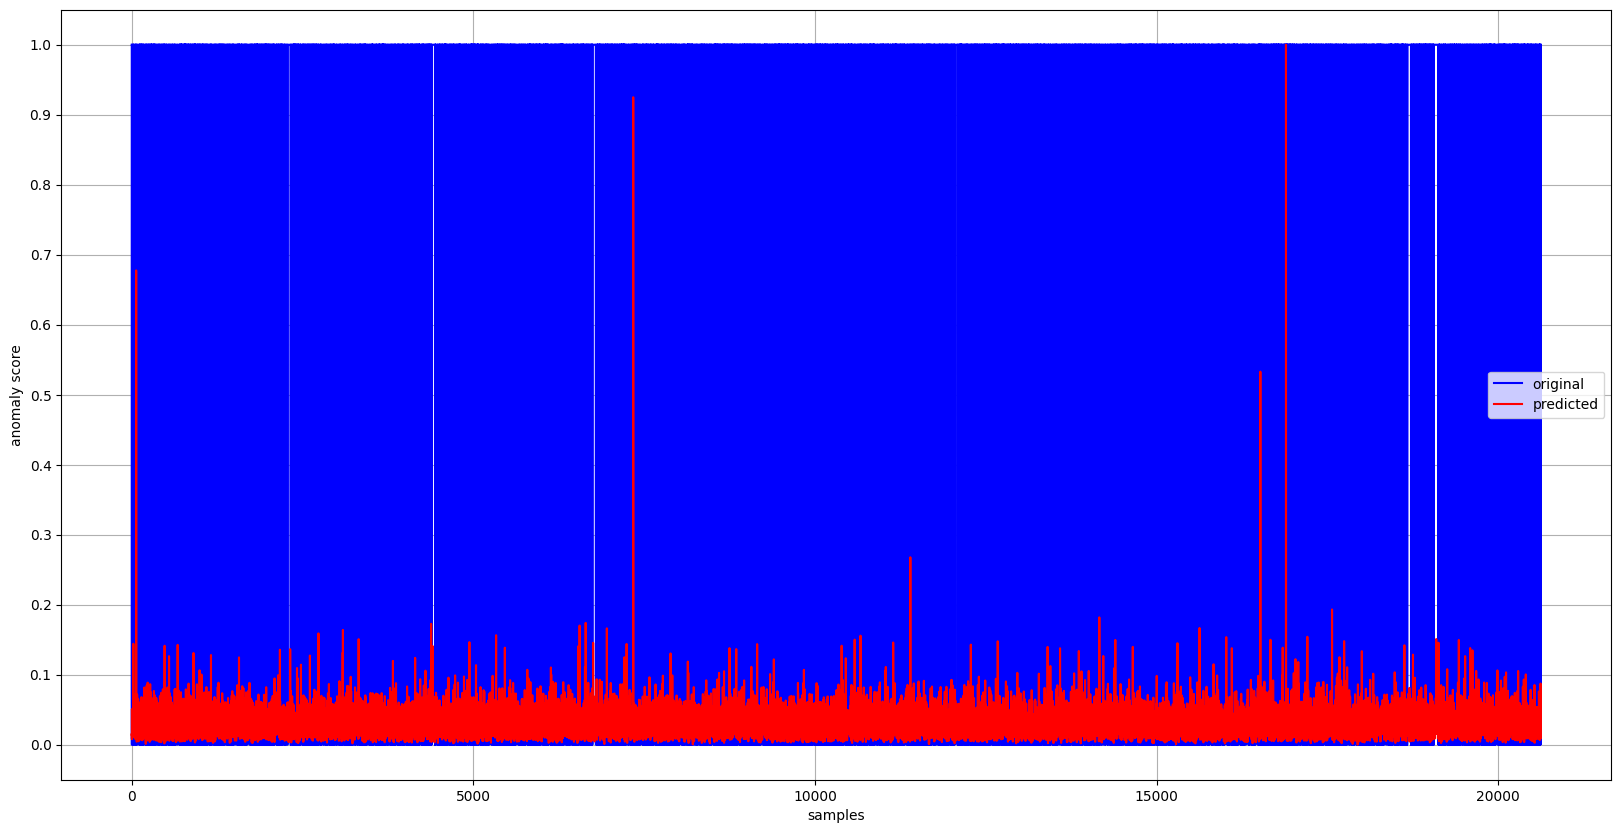

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(test_labels, c='blue', label='original')
plt.plot(anomaly_scores, c='red', label='predicted')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.grid()
plt.legend()
plt.show()

Measuring the effectiveness of classifier

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)

In [ ]:
auc = roc_auc_score(test_labels, anomaly_scores)
print('Area under ROC curve: {}'.format(auc))

Area under ROC curve: 0.6595118971500902


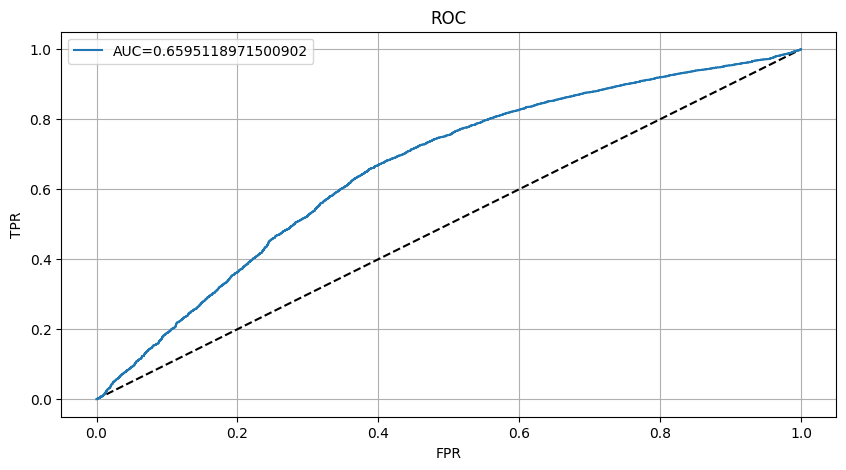

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color = 'black', linestyle='--')
plt.plot(fpr, tpr, label='AUC={}'.format(auc))
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()


Identifying anomalies in test set

In [ ]:
anomaly_combinations = [(anomaly_scores>i).astype(np.int32) for i in thresholds]
f1_scores = [f1_score(test_labels, i) for i in anomaly_combinations]

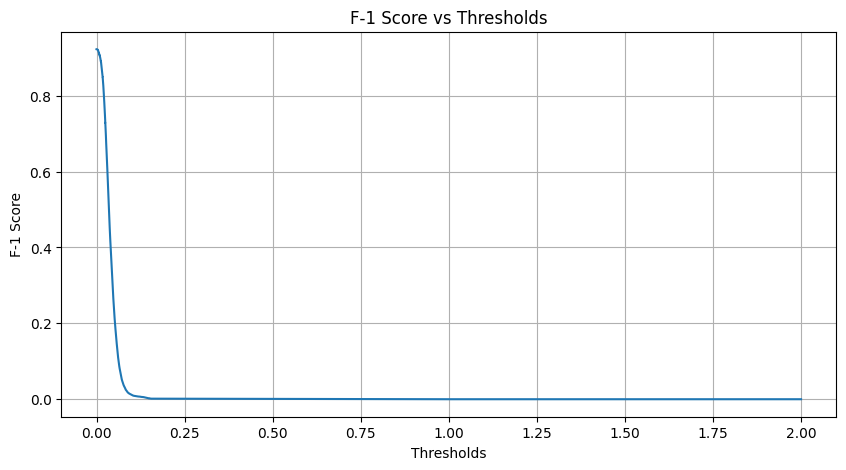

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('F-1 Score')
plt.title('F-1 Score vs Thresholds')
plt.show()

In [ ]:
max_f1_score = np.max(f1_scores)
best_threshold = thresholds[f1_scores.index(max_f1_score)]
print('best threshold = {}'.format(best_threshold))

best threshold = 0.0


In [ ]:
anomaly_indicator = (anomaly_scores>best_threshold).astype(np.int32)

In [ ]:
confusion_matrix(test_labels, anomaly_indicator)

array([[    0,  2958],
       [    1, 17666]])

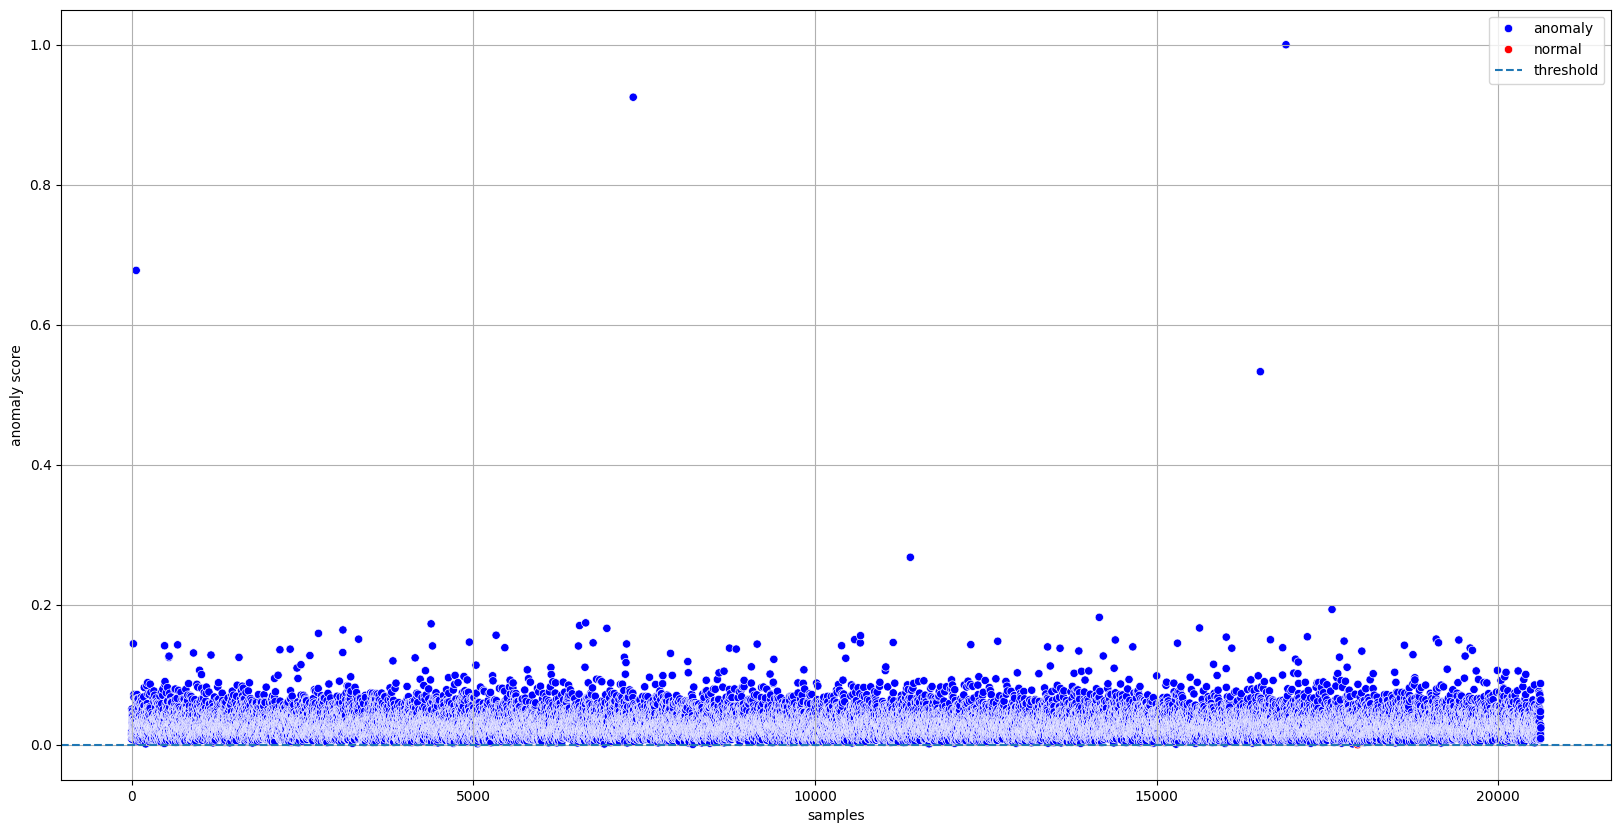

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(anomaly_scores)), y= anomaly_scores, hue=['normal' if i==0 else 'anomaly' for i in anomaly_indicator],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = best_threshold, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

In [ ]:
precision = precision_score(test_labels, anomaly_indicator)
recall = recall_score(test_labels, anomaly_indicator)
f1_sc = f1_score(test_labels, anomaly_indicator)
accuracy_sc = accuracy_score(test_labels, anomaly_indicator)

In [ ]:
print('Model has the following classification metrics:\n precision = {}\n recall = {}\n f1_score = {}\n accuracy_score = {}'
      .format(precision, recall, f1_sc, accuracy_sc))

Model has the following classification metrics:
 precision = 0.8565748642358417
 recall = 0.9999433972943906
 f1_score = 0.9227233553576558
 accuracy_score = 0.8565333333333334
